In [1]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
import os
os.environ.setdefault("HF_HOME", "/data/mjh24/hf")
os.environ.setdefault("TRANSFORMERS_CACHE", "/data/mjh24/hf/transformers")
os.makedirs(os.environ["TRANSFORMERS_CACHE"], exist_ok=True)
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from Stage2.txtGraphPruning.display_txt_graph import draw_graph_from_arrays
from Stage2.txtGraphPruning.prune_txt_graph import main as prune_txt_graph
from Stage2.classifyingEdges.classifyingTextNodes import clean_instructional_text
from Stage2.classifyingEdges.classifyingAnEdge import classify_link_pairs_zero_shot
from pathlib import Path
import numpy as np

CLIP_TO_N_EDGES_PER_NODE = 10 # This is to clip all the outgoing edges per node to a certain number
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
REMOVE_DUPES = False

/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# Load model
model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

# Load the website
url = "/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
# url = "https://westinghousenuclear.com/"
# url = "https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/"
# url = r"https://www.bbc.co.uk/news/live/cev28rvzlv1t"
# url = "https://www.nfl.com/teams/" # Great to show teams and structured data
# url = "https://www.energy.gov/ne/articles/advantages-and-challenges-nuclear-energy" #Great to show semi structured webpages with titles
# url = "https://westinghousenuclear.com/nuclear-fuel/fuel-fabrication-operations/"
# url = "https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/"
htmlFile = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html")
# downloadHTML(url,1,htmlFile)

In [3]:
# Get label edges from text nodes in the website
sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(url, model, alreadyConvertedToGraph="/vol/bitbucket/mjh24/IAEA-thesis/data/0000_test", remove_dupes=REMOVE_DUPES)
model.to("cpu")         # offload to CPU
if torch.cuda.is_available():
    torch.cuda.empty_cache() # reclaim GPU cache

/vol/bitbucket/mjh24/IAEA-thesis/Stage2/txtGraphExtraction/extract_mini_txt_graphs_helper.py:141: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(


In [4]:
# Normalise the text
normtxt = []
for a, b in txts_extracted:
    normtxt.append([normalise_text(a, "%'\\s"), normalise_text(b, "%'\\s")])
txts, probs, sorted_label_index, xpaths = np.array(normtxt), np.array(probs_extracted), np.array(sorted_label_index_extracted), np.array(xpaths_extracted)

In [5]:
# Remove all html instructional labels
txtsShortened = [[a.split(".")[0], b.split(".")[0]] for a, b in txts]
isInstruction, instructionalTxt = clean_instructional_text(txtsShortened, batch_size=32)
opmask = np.array(isInstruction, dtype=bool)
mask = np.logical_not(opmask)

for key, value in instructionalTxt.items():
    if value == 1:
        print(key)

send to friend
contact
privacy policy
about us
view dvd releases


In [6]:
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

In [7]:
# -- RUN THE MAIN PRUNING MASK --
mask = prune_txt_graph(probs, sorted_label_index, toloerance=0.01, remove_dupes=REMOVE_DUPES)

# Concatanate and apply masks if we want specific text
mask = mask 
print(len(sorted_label_index), " -> ", len(sorted_label_index[mask]))
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
# -- PRUNING FINISHED --

11772  ->  499


In [ ]:
# Classify the edges
classification, scores = classify_link_pairs_zero_shot(txts, batch_size=64, confidence_Factor=0.7, return_scores=True)

Device set to use cuda:0


In [9]:
if len(classification) != len(txts):
    raise Exception("The classification is not the same length as the number of edges")
for (pair, lab, sc) in zip(txts, classification, scores or []):
        print(lab, pair, "| scores:", {k: round(v, 3) for k, v in sc.items()})

1 ['british columbia canada' 'set in'] | scores: {1: 0.8, 2: 0.567, 3: 0.108, 4: 0.146}
1 ['set in' 'british columbia canada'] | scores: {1: 0.8, 2: 0.567, 3: 0.108, 4: 0.146}
1 ['for sexuality and some language' 'mpaa reasons'] | scores: {1: 0.528, 2: 0.264, 3: 0.008, 4: 0.015}
1 ['mpaa reasons' 'for sexuality and some language'] | scores: {1: 0.528, 2: 0.264, 3: 0.008, 4: 0.015}
4 ['addict' 'accident'] | scores: {1: 0.751, 2: 0.631, 3: 0.041, 4: 0.839}
4 ['accident' 'addict'] | scores: {1: 0.751, 2: 0.631, 3: 0.041, 4: 0.839}
3 ['other related works' 'is related to'] | scores: {1: 0.222, 2: 0.154, 3: 0.277, 4: 0.064}
3 ['is related to' 'other related works'] | scores: {1: 0.222, 2: 0.154, 3: 0.277, 4: 0.064}
4 ['drugs' 'accident'] | scores: {1: 0.806, 2: 0.626, 3: 0.007, 4: 0.724}
4 ['accident' 'drugs'] | scores: {1: 0.806, 2: 0.626, 3: 0.007, 4: 0.724}
1 ['in a minor key' 'moods'] | scores: {1: 0.502, 2: 0.363, 3: 0.03, 4: 0.072}
1 ['moods' 'in a minor key'] | scores: {1: 0.502, 2: 

['british columbia canada' 'set in']
['set in' 'british columbia canada']
['for sexuality and some language' 'mpaa reasons']
['mpaa reasons' 'for sexuality and some language']
['addict' 'accident']
['accident' 'addict']
['other related works' 'is related to']
['is related to' 'other related works']
['drugs' 'accident']
['accident' 'drugs']
['in a minor key' 'moods']
['moods' 'in a minor key']
['drugs' 'addict']
['addict' 'drugs']
['canada' 'r']
['r' 'canada']
['director' 'atom egoyan']
['atom egoyan' 'director']
['panavision' 'corrections to this entry']
['lawyer' 'accident']
['accident' 'lawyer']
['category' 'feature']
['feature' 'category']
['lawyer' 'addict']
['addict' 'lawyer']
['year' '1997']
['1997' 'year']
['drama' 'genres']
['genres' 'drama']
['panavision' 'cinematic process']
['cinematic process' 'panavision']
['british columbia canada' 'corrections to this entry']
['lawyer' 'drugs']
['drugs' 'lawyer']
['disaster' 'addict']
['addict' 'disaster']
['disaster' 'drugs']
['drugs' '

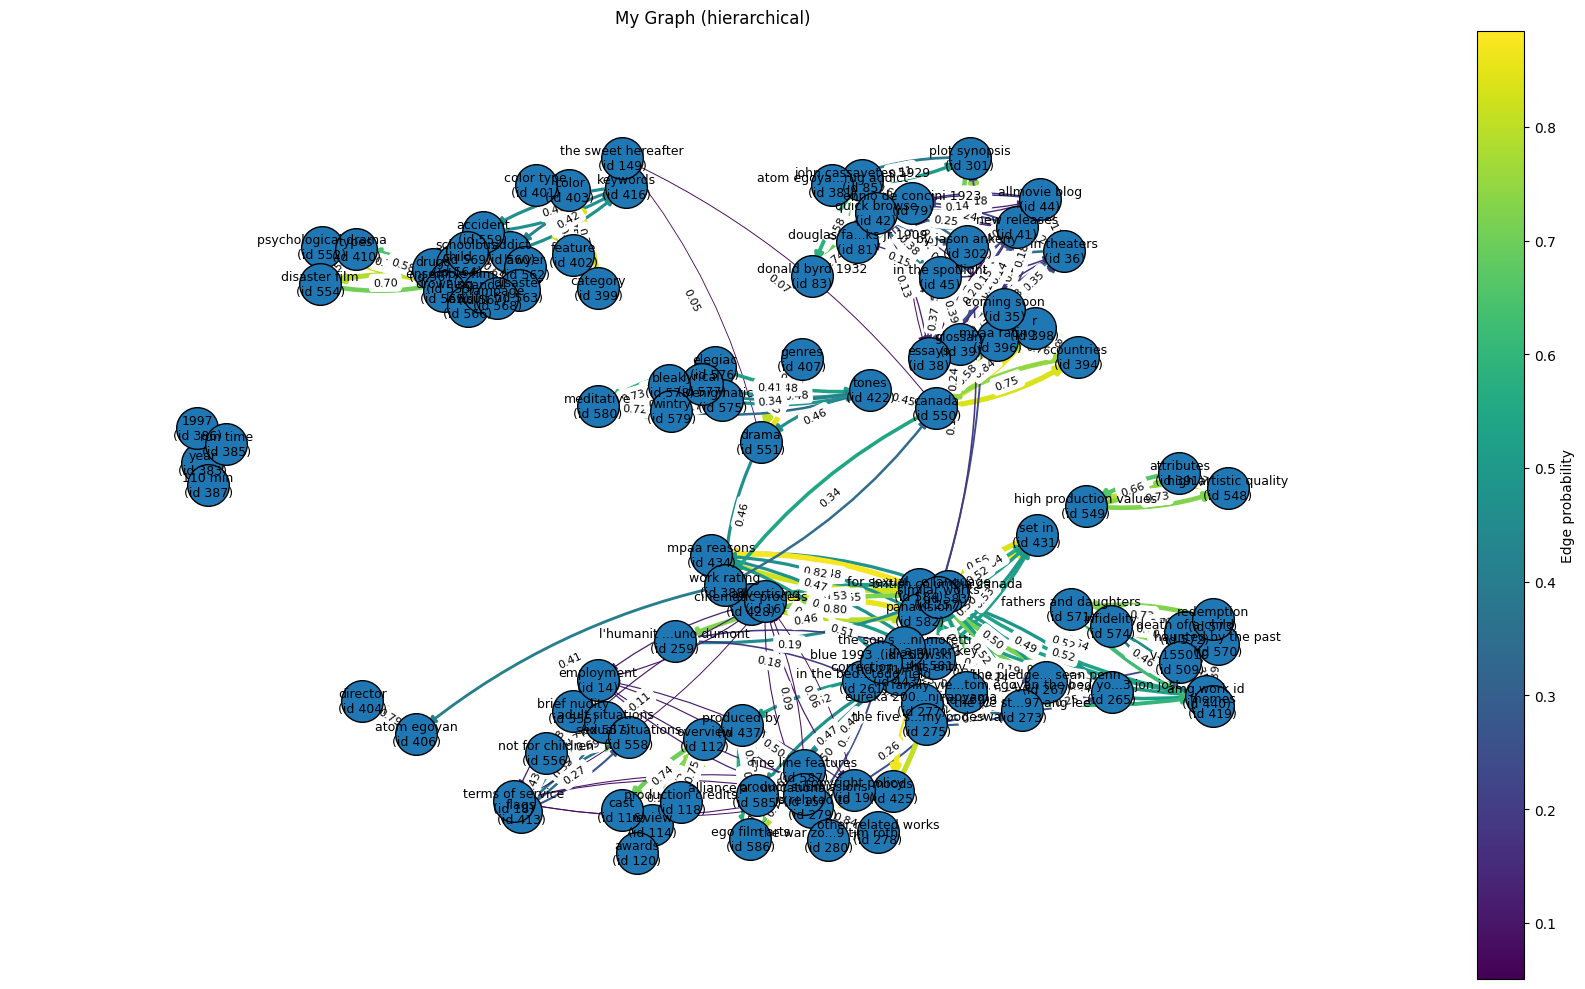

{'G': <networkx.classes.digraph.DiGraph at 0x7894aef4de50>,
 'pos': {583: array([ 0.3165633 , -0.23476165]),
  431: array([ 0.47286863, -0.09011516]),
  584: array([ 0.26617547, -0.22948821]),
  434: array([-0.09857738, -0.14236024]),
  560: array([-0.45066057,  0.64632051]),
  559: array([-0.49942166,  0.69665387]),
  278: array([ 0.19423199, -0.86173804]),
  279: array([ 0.07879355, -0.79708766]),
  561: array([-0.58576751,  0.60089282]),
  581: array([ 0.29256335, -0.40766169]),
  425: array([ 0.22119457, -0.75420755]),
  550: array([0.29686628, 0.2412056 ]),
  398: array([0.4694488 , 0.44862992]),
  404: array([-0.71097359, -0.52045365]),
  406: array([-0.61628147, -0.60495537]),
  582: array([ 0.26723357, -0.29417236]),
  443: array([ 0.22935855, -0.45158387]),
  562: array([-0.42505042,  0.60704022]),
  399: array([-0.2965373 ,  0.55152152]),
  402: array([-0.34063231,  0.63719417]),
  383: array([-0.9913669 ,  0.09856296]),
  386: array([-1.        ,  0.18924343]),
  551: array(

In [10]:
# Display the graph
textmask = np.array([True]*len(txts))
#textmask = filterTextMask(txts, "%", False) #& mask = keepTopKMask(txts, 1)

numToShow=-1
for row in zip(sorted_label_index[textmask][:numToShow], xpaths[textmask][:numToShow], txts[textmask][:numToShow], probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=txts[textmask][:numToShow],
    id_edge_pairs=sorted_label_index[textmask][:numToShow],
    xpath_edge_pairs=xpaths[textmask][:numToShow],
    probs=probs[textmask][:numToShow],
    layout="spring",
    rankdir="TB",         # or "TB" for top→bottom
    layer_spacing=5.0,    # spread layers further
    node_spacing=2.5,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)